准备工作

对于函数逼近，这里的损失函数是 MSE。输入应该归一化，隐藏层是 ReLU，输出层最好是 Sigmoid。

1.导入需要用到的模块：sklearn，该模块可以用来获取数据集，预处理数据，并将其分成训练集和测试集；pandas，可以用来分析数据集；matplotlib 和 seaborn 可以用来可视化：

In [2]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
%matplotlib inline

2.加载数据集并创建Pandas数据帧来分析数据

In [3]:
boston = datasets.load_boston()
df = pd.DataFrame(boston.data,columns=boston.feature_names)
df['target'] = boston.target

3.了解一些关于数据的细节

In [4]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


4.找到输入的不同特征与输出之间的关联：

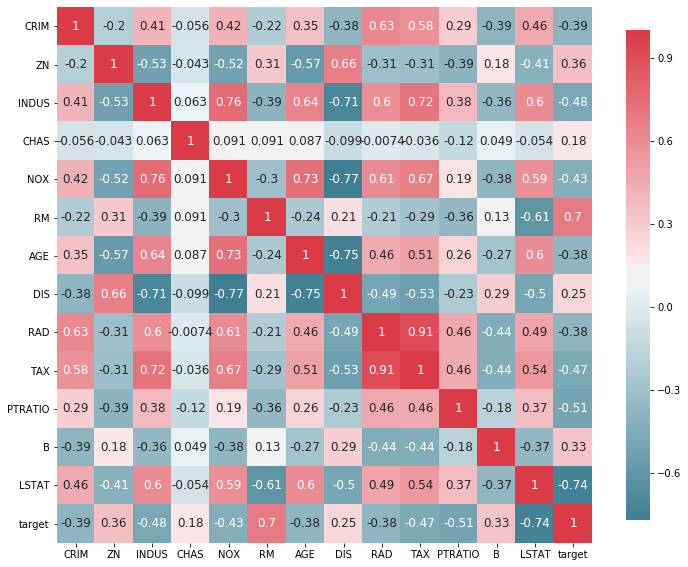

In [5]:
color_map,ax = plt.subplots(figsize=(12,10))
corr = df.corr(method='pearson')
cmap = sns.diverging_palette(220,10,as_cmap=True)
_ = sns.heatmap(corr,cmap=cmap,square=True,cbar_kws={'shrink':.9},ax=ax,annot=True,annot_kws={'fontsize':12})

5.从前面的代码中，可以看到三个参数 RM、PTRATIO 和 LSTAT 在幅度上与输出之间具有大于 0.5 的相关性。选择它们进行训练。将数据集分解为训练数据集和测试数据集。使用 MinMaxScaler 来规范数据集。
需要注意的一个重要变化是，由于神经网络使用 Sigmoid 激活函数（Sigmoid 的输出只能在 0～1 之间），所以还必须对目标值 Y 进行归一化：

In [6]:
X_train,X_test,y_train,y_test = train_test_split(df[['RM','LSTAT','PTRATIO']],df[['target']],test_size=0.3,random_state=0)

In [7]:
X_train = MinMaxScaler().fit_transform(X_train)
y_train = MinMaxScaler().fit_transform(y_train)
X_test = MinMaxScaler().fit_transform(X_test)
y_test = MinMaxScaler().fit_transform(y_test)

6.定义常量和超参数

In [19]:
m = len(X_train)
n = 3 # 选取了3个特征
n_hidden = 20 # 隐藏层的神经元个数

batch_size = 200
eta = 0.01
max_epoch = 1000

7.创建一个单隐藏层和多层感知机模型

In [9]:
def multilayer_perceptron(x):
    fc1 = layers.fully_connected(x,n_hidden,activation_fn=tf.nn.relu,scope='fc1')
    out = layers.fully_connected(fc1,1,activation_fn=tf.sigmoid,scope='out')
    return out

8.声明训练数据的占位符并定义损失和优化器

In [10]:
x = tf.placeholder(tf.float32,name='X',shape=[m,n])
y = tf.placeholder(tf.float32,name='Y')
y_hat = multilayer_perceptron(x)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
correct_prediction = tf.square(y - y_hat)
mse = tf.reduce_mean(tf.cast(correct_prediction,"float"))
train = tf.train.AdamOptimizer(learning_rate=eta).minimize(mse)
init = tf.global_variables_initializer()

9.执行计算图

In [20]:
with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('graphs',sess.graph)
    # 训练模型100次
    for i in range(max_epoch):
        _,l,p = sess.run([train,mse,y_hat],feed_dict={x:X_train,y:y_train})
        if i%100 == 0:
            print('Epoch {0}:Loss {1}'.format(i,l))
    print("Optimization Finished!")

Epoch 0:Loss 0.07436423748731613
Epoch 100:Loss 0.010157547891139984
Epoch 200:Loss 0.008441328071057796
Epoch 300:Loss 0.007769642397761345
Epoch 400:Loss 0.007633527275174856
Epoch 500:Loss 0.007565021049231291
Epoch 600:Loss 0.0074388510547578335
Epoch 700:Loss 0.0073964884504675865
Epoch 800:Loss 0.007365135010331869
Epoch 900:Loss 0.0073348600417375565
Optimization Finished!


In [30]:
# 测试模型，计算准确率
accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

Mean Error: Tensor("Mean_11:0", shape=(), dtype=float32)


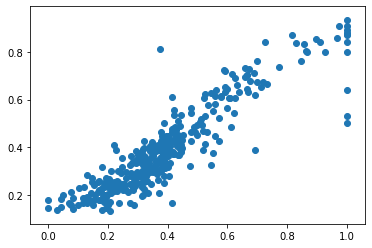

In [35]:
# with tf.Session() as sess:
print("Mean Error:",accuracy)
plt.scatter(y_train,p)